In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [13]:
# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.simplefilter("ignore")

In [14]:
from sklearn import metrics

In [15]:
from tensorflow.keras.utils import plot_model

In [18]:
# read in the character.csv file
df=pd.read_csv(r'C:\Users\Dell\OneDrive\Desktop\SJC\character.csv')
datasets=df.groupby('data set')
train_df=datasets.get_group('train')
test_df=datasets.get_group('test')
valid_df=datasets.get_group('valid')

In [38]:
# change the filepaths column to be the full path to an image
train_df['filepaths']=(r'C:\Users\Dell\OneDrive\Desktop\SJC\HCC\Train')
test_df['filepaths']=(r'C:\Users\Dell\OneDrive\Desktop\SJC\HCC\Test')
valid_df['filepaths']=(r'C:\Users\Dell\OneDrive\Desktop\SJC\HCC\valid')
# print out an imagepath to check
print(train_df['filepaths'].iloc[0])
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
# check the class sample balance of the train_df dataframe
print(train_df['labels'].value_counts())

C:\Users\Dell\OneDrive\Desktop\SJC\HCC\Train
train_df length:  11220   test_df length:  600   valid_df length:  600
savory      5610
unsavory    5610
Name: labels, dtype: int64


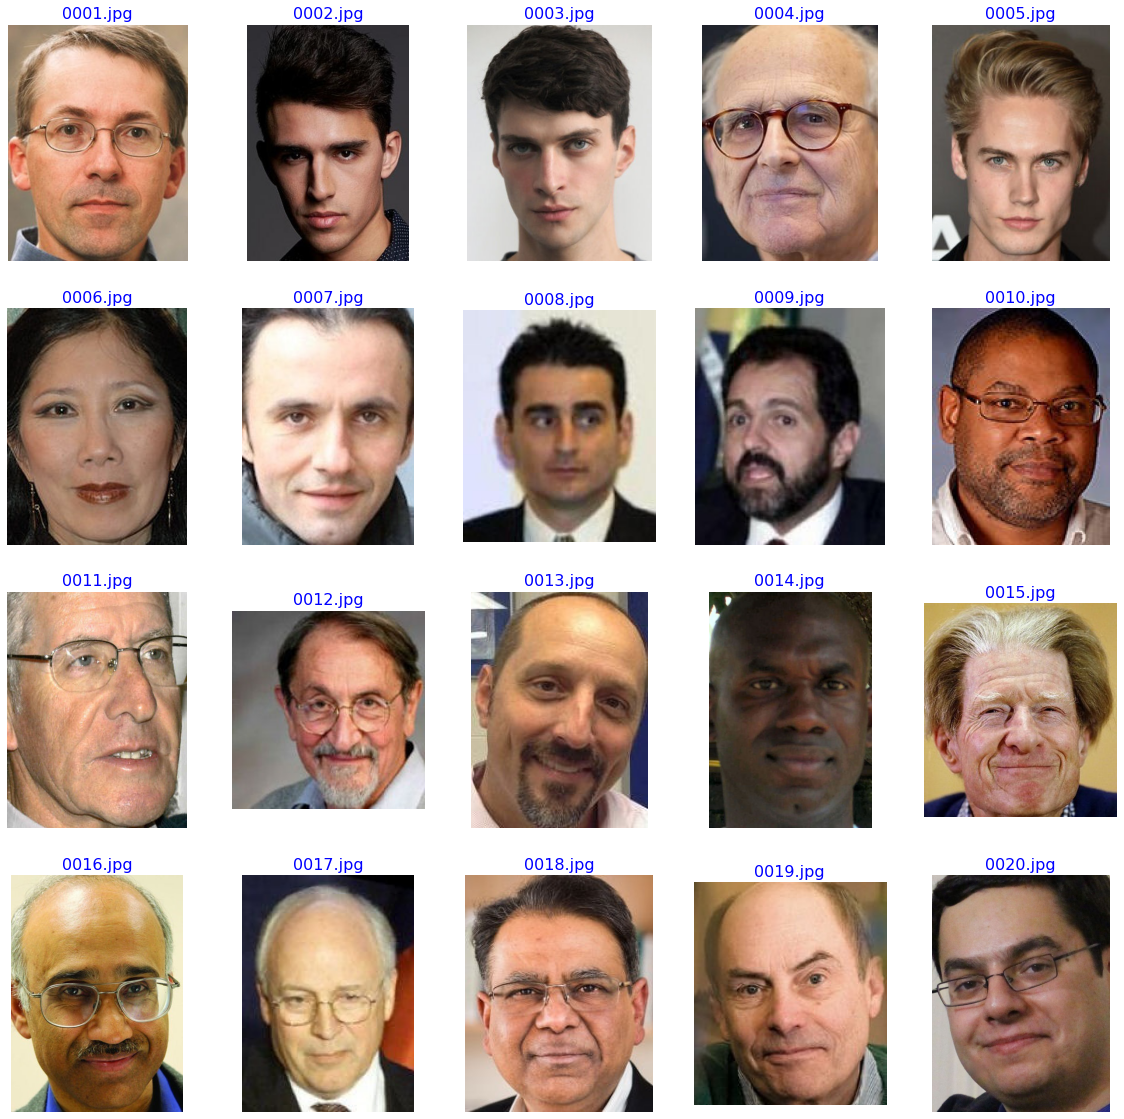

Average height=  377   average width=  294  average aspect ratio h/w=  1.282312925170068  image shape:  (300, 233, 3)


In [32]:
savory_train_dir=(r'C:\Users\Dell\OneDrive\Desktop\SJC\HCC\Train\savory') # select one of the class directories in train set
flist=sorted(os.listdir(savory_train_dir)) # get a list of the files
ht, wt, file_count = 0,0,200
plt.figure(figsize=(20,20))
for i, f in enumerate(flist): # iterate through the files
    if i >=file_count:
        break  # only lok at first file_count number of files to save time
    else: #As long as we are here might as well show 20 training images
        imgpath=os.path.join(savory_train_dir,f)
        img=plt.imread(imgpath)
        h,w,c=np.shape(img) # use numpy shape returns height, width
        ht += h
        wt += w
        if i < 20:
            plt.subplot(4,5,i+1)
            plt.axis('off')
            plt.title(f, color='blue', fontsize=16)
            plt.imshow(img)
plt.show()
ave_h=int(ht/file_count)
ave_w=int(wt/file_count)
aspect_ratio=ave_h/ave_w
# select an image size for the model 300 pixel height should be adequate to capture image features
img_size=(300, int(300/aspect_ratio))
img_shape=(img_size[0], img_size[1], 3)
print('Average height= ', ave_h, '  average width= ', ave_w, ' average aspect ratio h/w= ', aspect_ratio, ' image shape: ', img_shape)

In [39]:
# create train, test and valid generators
batch_size=30 # We will use and EfficientetB3 model, with image size of (300,233) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True)
t_and_v_gen=ImageDataGenerator()
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^12s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^12s}{str(index):^12s}')

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
test batch size:  75   test steps:  8  number of classes :  0
 class name class index 


### CNN Model

In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

In [41]:
model0 = Sequential()

model0.add(Conv2D(filters=64, kernel_size = (5,5), input_shape = img_shape, activation = 'relu'))
model0.add(BatchNormalization(axis=3))
model0.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model0.add(MaxPooling2D((2, 2)))
model0.add(BatchNormalization(axis=3))
model0.add(Dropout(0.1))

#model0.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
#model0.add(BatchNormalization(axis=3))
#model0.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
#model0.add(MaxPooling2D((2, 2)))
#model0.add(BatchNormalization(axis=3))
#model0.add(Dropout(0.1))

model0.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model0.add(BatchNormalization(axis=3))
model0.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model0.add(MaxPooling2D((2, 2)))
model0.add(BatchNormalization(axis=3))
model0.add(Dropout(0.1))

model0.add(Flatten())

model0.add(Dense(256, activation='relu'))
model0.add(BatchNormalization())
model0.add(Dropout(0.5))

#model0.add(Dense(256, activation='relu'))
#model0.add(BatchNormalization())
#model0.add(Dropout(0.5))

model0.add(Dense(2, activation='softmax'))

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 296, 229, 64)      4864      
                                                                 
 batch_normalization (BatchN  (None, 296, 229, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 292, 225, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 146, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 146, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [42]:
plot_model(model0,show_shapes=True,show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [44]:
# compile model
model0.compile(Adamax(learning_rate = 1e-3),loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
# create 2 useful callbacks, one to control the learning rate, and one to control early stopping based on validation loss
rlronp0=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop0=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks0=[rlronp0, estop0]

In [46]:
# train the model
epochs=20
cnn_history=model0.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks0,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [47]:
#define a function to plot the training data
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
     axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
tr_plot(cnn_history, 0)

IndentationError: unexpected indent (<ipython-input-47-dced891f8dae>, line 21)

In [48]:
tr_plot(cnn_history, 0)

NameError: name 'tr_plot' is not defined

In [49]:
# use the trained model to make predictions and calculate accuracy since this is binary classification accuracy is sufficient
preds0=model0.predict(test_gen, steps=test_steps, verbose=1)
preds0_labels = []
errors0=0
for i, p in enumerate(preds0):
    index=np.argmax(p)
    if class_indices[index] != labels[i]:
        errors0 +=1
    preds0_labels.append(class_indices[index])
acc0= (1.0-errors0/len(preds0)) * 100 
print(f'There were {errors0} errors in {len(preds0)} trials for an accuracy of  {acc0:6.2f} %')

ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [50]:
print(metrics.classification_report(labels, preds0_labels,digits = 4))

NameError: name 'preds0_labels' is not defined

In [51]:
# now run the predictor with average=True
result=predictor(sdir,img_size, average=True)

NameError: name 'predictor' is not defined